# Proof of concept notebook for the Frame Booster project
- Author: Kamil Barszczak
- Contact: kamilbarszczak62@gmail.com
- Project: https://github.com/kbarszczak/Frame_booster

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchsummary
import torchvision
import torch
import time

#### Notebook parameters

In [2]:
base_path = 'E:/Data/Video_Frame_Interpolation/processed/vimeo90k_pytorch'
data_subdir = 'data'
train_ids = 'train.txt'
test_ids = 'test.txt'
valid_ids = 'valid.txt'

width, height = 256, 144
epochs = 5
batch = 2

#### Setup device

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


#### Load datasets

In [4]:
class ByteImageDataset(data.Dataset):
    def __init__(self, path, subdir, split_filename, shape):
        self.path = path
        self.subdir = subdir
        self.shape = shape
        self.ids = pd.read_csv(os.path.join(path, split_filename), names=["ids"])
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.subdir, str(self.ids.iloc[idx, 0]))
        
        imgs = [
            self._read_bytes_to_tensor(os.path.join(img_path, 'im1')),
            self._read_bytes_to_tensor(os.path.join(img_path, 'im3'))
        ]
        true = self._read_bytes_to_tensor(os.path.join(img_path, 'im2'))
        
        return imgs, true
    
    def _read_bytes_to_tensor(self, path):
        with open(path, 'rb') as bf:
            return torch.permute(torch.reshape(torch.frombuffer(bf.read(), dtype=torch.float), self.shape), (2, 0, 1))

In [5]:
train_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = data_subdir,
        split_filename = train_ids,
        shape = (height, width, 3)
    ),
    shuffle = True,
    batch_size = batch,
    drop_last = True
)

test_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = data_subdir,
        split_filename = test_ids,
        shape = (height, width, 3)
    ),
    batch_size = batch,
    drop_last = True
)

valid_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = data_subdir,
        split_filename = valid_ids,
        shape = (height, width, 3)
    ),
    batch_size = batch,
    drop_last = True
)

In [6]:
print(f'Training batches: {len(train_dataloader)}')
print(f'Testing batches: {len(test_dataloader)}')
print(f'Validating batches: {len(valid_dataloader)}')

Training batches: 25000
Testing batches: 1500
Validating batches: 500


#### Create the model

In [7]:
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))


def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)


def psnr(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    psnr = 20 * torch.log10(1 / torch.sqrt(mse))
    return 1 - psnr / 40.0


# def ssim(y_true, y_pred):
#     ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
#     return 1 - ssim

    
def loss(y_true, y_pred):
    # ssim_ = ssim(y_true, y_pred)
    psnr_ = psnr(y_true, y_pred)
    mse_ = mse(y_true, y_pred)
    mae_ = mae(y_true, y_pred)
    
    # return ssim_ + psnr_ + 5.0*l1_ + 10.0*l2_    
    return psnr_ + 5.0*mae_ + 10.0*mse_

In [8]:
class FlowEstimation(nn.Module):
    def __init__(self, flow_input_chanels,
                flow_info = {
                    "filter_counts": [32, 64, 64, 16, 12, 12],
                    "filter_sizes": [(3, 3), (3, 3), (3, 3), (3, 3), (1, 1), (1, 1)],
                    "filter_strides": [1, 1, 1, 1, 1, 1],
                    "filter_padding": [1, 1, 1, 1, 0, 0],
                    "activations": [nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU()],
                }, **kwargs):
        super(FlowEstimation, self).__init__(**kwargs)

        modules = []
        last_output_size = flow_input_chanels
        for fcount, fsize, fstride, fpad, fact in zip(flow_info['filter_counts'], flow_info['filter_sizes'], flow_info['filter_strides'], flow_info['filter_padding'], flow_info['activations']):
            modules.append(nn.Conv2d(last_output_size, fcount, fsize, fstride, fpad))
            modules.append(fact)
            last_output_size = fcount

        modules.append(nn.Conv2d(last_output_size, 2, 1))
        self.flow = nn.Sequential(*modules)

    def forward(self, x):
        return self.flow(x)

In [9]:
class BidirectionalFeatureWarp(nn.Module):
    def __init__(self, flow_prediction, interpolation='bilinear', **kwargs):
        super(BidirectionalFeatureWarp, self).__init__(**kwargs)
        
        self.flow_prediction = flow_prediction
        self.flow_upsample_1_2 = nn.Upsample(scale_factor=(2, 2), mode=interpolation)
        self.flow_upsample_2_1 = nn.Upsample(scale_factor=(2, 2), mode=interpolation)

    def forward(self, input_1, input_2, flow_1_2, flow_2_1):
        if torch.is_tensor(flow_1_2) and torch.is_tensor(flow_2_1):
            input_1_warped_1 = BidirectionalFeatureWarp.warp(input_1, flow_1_2)
            input_2_warped_1 = BidirectionalFeatureWarp.warp(input_2, flow_2_1)
        else:
            input_1_warped_1 = input_1
            input_2_warped_1 = input_2
            
        flow_change_1_2_concat = torch.cat([input_2, input_1_warped_1], dim=1)
        flow_change_1_2 = self.flow_prediction(flow_change_1_2_concat)
        
        flow_change_2_1_concat = torch.cat([input_1, input_2_warped_1], dim=1)
        flow_change_2_1 = self.flow_prediction(flow_change_2_1_concat)
        
        if torch.is_tensor(flow_1_2) and torch.is_tensor(flow_2_1):
            flow_1_2_changed = flow_1_2 + flow_change_1_2
            flow_2_1_changed = flow_2_1 + flow_change_2_1
        else:
            flow_1_2_changed = flow_change_1_2
            flow_2_1_changed = flow_change_2_1
            
        input_1_warped_2 = BidirectionalFeatureWarp.warp(input_1, flow_1_2_changed)
        input_2_warped_2 = BidirectionalFeatureWarp.warp(input_2, flow_2_1_changed)
        flow_1_2_changed_upsampled = self.flow_upsample_1_2(flow_1_2_changed)
        flow_2_1_changed_upsampled = self.flow_upsample_2_1(flow_2_1_changed)
        
        return input_1_warped_2, input_2_warped_2, flow_1_2_changed_upsampled, flow_2_1_changed_upsampled
    
    @staticmethod
    def warp(image: torch.Tensor, flow: torch.Tensor) -> torch.Tensor:
        B, C, H, W = image.size()

        xx = torch.arange(0, W).view(1 ,-1).repeat(H, 1)
        yy = torch.arange(0, H).view(-1 ,1).repeat(1, W)
        xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
        yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)

        grid = torch.cat((xx, yy), 1).float()
        if image.is_cuda:
            grid = grid.cuda()

        vgrid = grid + flow
        vgrid[:, 0, :, :] = 2.0 * vgrid[: ,0 ,: ,:].clone() / max(W - 1, 1) - 1.0
        vgrid[:, 1, :, :] = 2.0 * vgrid[: ,1 ,: ,:].clone() / max(H - 1, 1) - 1.0

        vgrid = vgrid.permute(0, 2, 3, 1)
        flow = flow.permute(0, 2, 3, 1)
        output = F.grid_sample(image, vgrid, align_corners=False)

        return output

In [27]:
class FBNet(nn.Module):
    def __init__(self, 
                 input_shape,
                 encoder_filters = [
                     [96, 80, 64, 64],  # encoder_filters_col_1
                     [80, 64, 64],  # encoder_filters_col_2
                     [64, 64]  # encoder_filters_col_3
                 ], 
                 decoder_filters = [40, 40],  # decoder_filters
                 flow_info = [
                     {  # flow_1
                        "filter_counts": [32, 48, 64, 80, 80, 48],
                        "filter_sizes": [7, 5, 5, 3, 1, 1],
                        "filter_strides": [1, 1, 1, 1, 1, 1],
                        "filter_padding": [3, 2, 2, 1, 0, 0],
                        "activations": [nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU()]
                     }, 
                     {  # flow_2
                        "filter_counts": [24, 32, 64, 64, 32],
                        "filter_sizes": [5, 3, 3, 1, 1],
                        "filter_strides": [1, 1, 1, 1, 1],
                        "filter_padding": [2, 1, 1, 0, 0],
                        "activations": [nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU()]
                     }, 
                     {  # flow_3
                        "filter_counts": [24, 48, 48, 16],
                        "filter_sizes": [3, 3, 1, 1],
                        "filter_strides": [1, 1, 1, 1],
                        "filter_padding": [1, 1, 0, 0],
                        "activations": [nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU()]
                     },
                 ], interpolation="bilinear", **kwargs):
        super(FBNet, self).__init__(**kwargs)
        
        self.c = input_shape[0]
        self.h = input_shape[1]
        self.w = input_shape[2]
        
        # ------------- Shared Conv2d, AvgPool2d & Resize encoding layers
        self.resize_1_2 = torchvision.transforms.Resize(size=(height//2, width//2), antialias=True)
        self.resize_1_4 = torchvision.transforms.Resize(size=(height//4, width//4), antialias=True)
        self.resize_1_8 = torchvision.transforms.Resize(size=(height//8, width//8), antialias=True)
        
        self.cnn_r1_c1 = nn.Conv2d(self.c, encoder_filters[0][0], 3, 1, 1)
        self.cnn_r2_c1 = nn.Conv2d(self.c, encoder_filters[0][1], 3, 1, 1)
        self.cnn_r3_c1 = nn.Conv2d(self.c, encoder_filters[0][2], 3, 1, 1)
        self.cnn_r4_c1 = nn.Conv2d(self.c, encoder_filters[0][3], 3, 1, 1)
        self.act_r1_c1 = nn.PReLU()
        self.act_r2_c1 = nn.PReLU()
        self.act_r3_c1 = nn.PReLU()
        self.act_r4_c1 = nn.PReLU()

        self.cnn_r2_c2 = nn.Conv2d(encoder_filters[0][0], encoder_filters[1][0], 3, 1, 1)
        self.cnn_r3_c2 = nn.Conv2d(encoder_filters[0][1], encoder_filters[1][1], 3, 1, 1)
        self.cnn_r4_c2 = nn.Conv2d(encoder_filters[0][2], encoder_filters[1][2], 3, 1, 1)
        self.act_r2_c2 = nn.PReLU()
        self.act_r3_c2 = nn.PReLU()
        self.act_r4_c2 = nn.PReLU()

        self.cnn_r3_c3 = nn.Conv2d(encoder_filters[1][0], encoder_filters[2][0], 3, 1, 1)
        self.cnn_r4_c3 = nn.Conv2d(encoder_filters[1][1], encoder_filters[2][1], 3, 1, 1)
        self.act_r3_c3 = nn.PReLU()
        self.act_r4_c3 = nn.PReLU()
        
        self.avg_r2_c1 = nn.AvgPool2d(2)
        self.avg_r3_c1 = nn.AvgPool2d(2)
        self.avg_r4_c1 = nn.AvgPool2d(2)
        
        self.avg_r3_c2 = nn.AvgPool2d(2)
        self.avg_r4_c2 = nn.AvgPool2d(2)
        
        # ------------- Feature warping layers 
        self.bidirectional_warp_row_1 = BidirectionalFeatureWarp(
            flow_prediction = FlowEstimation(
                flow_input_chanels = 2*encoder_filters[0][0],
                flow_info = flow_info[0]
            ),
            interpolation = interpolation
        )
        self.bidirectional_warp_row_2 = BidirectionalFeatureWarp(
            flow_prediction = FlowEstimation(
                flow_input_chanels = 2*(encoder_filters[0][1] + encoder_filters[1][0]),
                flow_info = flow_info[1]
            ),
            interpolation = interpolation
        )
        self.bidirectional_warp_row_3 = BidirectionalFeatureWarp(
            flow_prediction = FlowEstimation(
                flow_input_chanels = 2*(encoder_filters[0][2] + encoder_filters[1][1] + encoder_filters[2][0]),
                flow_info = flow_info[2]
            ),
            interpolation = interpolation
        )
        
        # ------------- Decoding Conv2d layers
        self.cnn_r4_1 = nn.Conv2d(encoder_filters[0][3] + encoder_filters[1][2] + encoder_filters[2][1], encoder_filters[0][2] + encoder_filters[1][1] + encoder_filters[2][0], 3, 1, 1)
        self.act_r4_1 = nn.PReLU()
        self.up_r4 = nn.Upsample(scale_factor=(2, 2), mode=interpolation)
        
        self.cnn_r3_1 = nn.Conv2d(encoder_filters[0][2] + encoder_filters[1][1] + encoder_filters[2][0], encoder_filters[0][1] + encoder_filters[1][0], 3, 1, 1)
        self.act_r3_1 = nn.PReLU()
        self.up_r3 = nn.Upsample(scale_factor=(2, 2), mode=interpolation)
        
        self.cnn_r2_1 = nn.Conv2d(encoder_filters[0][1] + encoder_filters[1][0], encoder_filters[0][0], 3, 1, 1)
        self.cnn_r2_2 = nn.Conv2d(encoder_filters[0][0], encoder_filters[0][0], 3, 1, 1)
        self.act_r2_1 = nn.PReLU()
        self.act_r2_2 = nn.PReLU()
        self.up_r2 = nn.Upsample(scale_factor=(2, 2), mode=interpolation)
        
        self.cnn_r1_1 = nn.Conv2d(encoder_filters[0][0], decoder_filters[0], 3, 1, 1)
        self.cnn_r1_2 = nn.Conv2d(decoder_filters[0], decoder_filters[1], 3, 1, 1)
        self.act_r1_1 = nn.PReLU()
        self.act_r1_2 = nn.PReLU()
        
        self.cnn_out = nn.Conv2d(decoder_filters[1], 3, 1, 1, 0)
        self.act_out = nn.Sigmoid()

    def forward(self, input_1_left, input_1_right):
        # ------------- Process left input
        input_2_left = self.resize_1_2(input_1_left)
        input_3_left = self.resize_1_4(input_2_left)
        input_4_left = self.resize_1_8(input_3_left)
        
        # Feature extraction for layer 1
        input_1_left_cnn_r1_c1 = self.act_r1_c1(self.cnn_r1_c1(input_1_left))
        input_2_left_cnn_r2_c1 = self.act_r2_c1(self.cnn_r2_c1(input_2_left))
        input_3_left_cnn_r3_c1 = self.act_r3_c1(self.cnn_r3_c1(input_3_left))
        input_4_left_cnn_r4_c1 = self.act_r4_c1(self.cnn_r4_c1(input_4_left))

        # Downsample layer 1
        input_1_left_cnn_r2_c1 = self.avg_r2_c1(input_1_left_cnn_r1_c1)
        input_2_left_cnn_r3_c1 = self.avg_r3_c1(input_2_left_cnn_r2_c1)
        input_3_left_cnn_r4_c1 = self.avg_r4_c1(input_3_left_cnn_r3_c1)

        # Feature extraction for layer 2
        input_1_left_cnn_r2_c2 = self.act_r2_c2(self.cnn_r2_c2(input_1_left_cnn_r2_c1))
        input_2_left_cnn_r3_c2 = self.act_r3_c2(self.cnn_r3_c2(input_2_left_cnn_r3_c1))
        input_3_left_cnn_r4_c2 = self.act_r4_c2(self.cnn_r4_c2(input_3_left_cnn_r4_c1))

        # Downsample layer 2
        input_1_left_cnn_r3_c2 = self.avg_r3_c2(input_1_left_cnn_r2_c2)
        input_2_left_cnn_r4_c2 = self.avg_r4_c2(input_2_left_cnn_r3_c2)

        # Feature extraction for layer 3
        input_1_left_cnn_r3_c3 = self.act_r3_c3(self.cnn_r3_c3(input_1_left_cnn_r3_c2))
        input_2_left_cnn_r4_c3 = self.act_r4_c3(self.cnn_r4_c3(input_2_left_cnn_r4_c2))

        # Concatenate
        concat_left_row_2 = torch.cat([input_2_left_cnn_r2_c1, input_1_left_cnn_r2_c2], dim=1)
        concat_left_row_3 = torch.cat([input_3_left_cnn_r3_c1, input_2_left_cnn_r3_c2, input_1_left_cnn_r3_c3], dim=1)
        concat_left_row_4 = torch.cat([input_4_left_cnn_r4_c1, input_3_left_cnn_r4_c2, input_2_left_cnn_r4_c3], dim=1)
        
        # Feature extraction left side output: 
        # * input_1_left_cnn_r1_c1
        # * concat_left_row_2
        # * concat_left_row_3
        # * concat_left_row_4
        
        # ------------- Process right input
        input_2_right = self.resize_1_2(input_1_right)
        input_3_right = self.resize_1_4(input_2_right)
        input_4_right = self.resize_1_8(input_3_right)

        # Feature extraction for layer 1
        input_1_right_cnn_r1_c1 = self.act_r1_c1(self.cnn_r1_c1(input_1_right))
        input_2_right_cnn_r2_c1 = self.act_r2_c1(self.cnn_r2_c1(input_2_right))
        input_3_right_cnn_r3_c1 = self.act_r3_c1(self.cnn_r3_c1(input_3_right))
        input_4_right_cnn_r4_c1 = self.act_r4_c1(self.cnn_r4_c1(input_4_right))

        # Downsample layer 1
        input_1_right_cnn_r2_c1 = self.avg_r2_c1(input_1_right_cnn_r1_c1)
        input_2_right_cnn_r3_c1 = self.avg_r3_c1(input_2_right_cnn_r2_c1)
        input_3_right_cnn_r4_c1 = self.avg_r4_c1(input_3_right_cnn_r3_c1)

        # Feature extraction for layer 2
        input_1_right_cnn_r2_c2 = self.act_r2_c2(self.cnn_r2_c2(input_1_right_cnn_r2_c1))
        input_2_right_cnn_r3_c2 = self.act_r3_c2(self.cnn_r3_c2(input_2_right_cnn_r3_c1))
        input_3_right_cnn_r4_c2 = self.act_r4_c2(self.cnn_r4_c2(input_3_right_cnn_r4_c1))

        # Downsample layer 2
        input_1_right_cnn_r3_c2 = self.avg_r3_c2(input_1_right_cnn_r2_c2)
        input_2_right_cnn_r4_c2 = self.avg_r4_c2(input_2_right_cnn_r3_c2)

        # Feature extraction for layer 3
        input_1_right_cnn_r3_c3 = self.act_r3_c3(self.cnn_r3_c3(input_1_right_cnn_r3_c2))
        input_2_right_cnn_r4_c3 = self.act_r4_c3(self.cnn_r4_c3(input_2_right_cnn_r4_c2))

        # Concatenate
        concat_right_row_2 = torch.cat([input_2_right_cnn_r2_c1, input_1_right_cnn_r2_c2], dim=1)
        concat_right_row_3 = torch.cat([input_3_right_cnn_r3_c1, input_2_right_cnn_r3_c2, input_1_right_cnn_r3_c3], dim=1)
        concat_right_row_4 = torch.cat([input_4_right_cnn_r4_c1, input_3_right_cnn_r4_c2, input_2_right_cnn_r4_c3], dim=1)

        # Feature extraction right side output: 
        # * input_1_right_cnn_r1_c1
        # * concat_right_row_2
        # * concat_right_row_3
        # * concat_right_row_4
        
        # ------------- Warping features at each level
        # Calculate the flow for each level using the input of current level and the upsampled flow from the level + 1
        bfe_4_i1, bfe_4_i2, bfe_4_f_1_2, bfe_4_f_2_1 = self.bidirectional_warp_row_3(concat_left_row_4, concat_right_row_4, None, None)
        bfe_3_i1, bfe_3_i2, bfe_3_f_1_2, bfe_3_f_2_1 = self.bidirectional_warp_row_3(concat_left_row_3, concat_right_row_3, bfe_4_f_1_2, bfe_4_f_2_1)
        bfe_2_i1, bfe_2_i2, bfe_2_f_1_2, bfe_2_f_2_1 = self.bidirectional_warp_row_2(concat_left_row_2, concat_right_row_2, bfe_3_f_1_2, bfe_3_f_2_1)
        bfe_1_i1, bfe_1_i2, _, _ = self.bidirectional_warp_row_1(input_1_left_cnn_r1_c1, input_1_right_cnn_r1_c1, bfe_2_f_1_2, bfe_2_f_2_1)

        # Flow estimation output: 
        # * (bfe_1_i1, bfe_2_i1, bfe_3_i1, bfe_4_i1) 
        # * (bfe_1_i2, bfe_2_i2, bfe_3_i2, bfe_4_i2)
        
        # ------------- Warped features fusion   
        # Merge row 4
        add_row_4 = bfe_4_i1 + bfe_4_i2
        cnn_row_4_1 = self.act_r4_1(self.cnn_r4_1(add_row_4))
        upsample_row_4 = self.up_r4(cnn_row_4_1)

        # Merge row 3
        add_row_3 = bfe_3_i1 + bfe_3_i2 + upsample_row_4
        cnn_row_3_1 = self.act_r3_1(self.cnn_r3_1(add_row_3))
        upsample_row_3 = self.up_r3(cnn_row_3_1)

        # Merge row 2
        add_row_2 = bfe_2_i1 + bfe_2_i2 + upsample_row_3
        cnn_row_2_1 = self.act_r2_1(self.cnn_r2_1(add_row_2))
        cnn_row_2_2 = self.act_r2_2(self.cnn_r2_2(cnn_row_2_1))
        upsample_row_2 = self.up_r2(cnn_row_2_2)

        # Merge row 1
        add_row_1 = bfe_1_i1 + bfe_1_i2 + upsample_row_2
        cnn_row_1_1 = self.act_r1_1(self.cnn_r1_1(add_row_1))
        cnn_row_1_2 = self.act_r1_2(self.cnn_r1_2(cnn_row_1_1))

        # Create the output layer
        fus_conv2d_outputs = self.act_out(self.cnn_out(cnn_row_1_2))
         
        # Feature fusion output: 
        # * fus_conv2d_outputs
        
        return fus_conv2d_outputs

In [28]:
fbnet = FBNet(input_shape = (3, width, height)).to(device)
torchsummary.summary(fbnet, [(3, 144, 256), (3, 144, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Resize-1           [-1, 3, 72, 128]               0
            Resize-2            [-1, 3, 36, 64]               0
            Resize-3            [-1, 3, 18, 32]               0
            Conv2d-4         [-1, 96, 144, 256]           2,688
             PReLU-5         [-1, 96, 144, 256]               1
            Conv2d-6          [-1, 80, 72, 128]           2,240
             PReLU-7          [-1, 80, 72, 128]               1
            Conv2d-8           [-1, 64, 36, 64]           1,792
             PReLU-9           [-1, 64, 36, 64]               1
           Conv2d-10           [-1, 64, 18, 32]           1,792
            PReLU-11           [-1, 64, 18, 32]               1
        AvgPool2d-12          [-1, 96, 72, 128]               0
        AvgPool2d-13           [-1, 80, 36, 64]               0
        AvgPool2d-14           [-1, 64,

#### Train the model

In [29]:
def norm_0_1(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_history(history, compress=None, norm=norm_0_1, exclude_valid=False, figsize=(10,5)):
    plt.clf()
    plt.figure(figsize=figsize)
    
    metrics = list(history.keys())
    metrics = [metric for metric in metrics if "val" not in metric]
    
    data = [(index, history[metric], history['val_'+metric], metric) for index, metric in enumerate(metrics)]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    org_size = len(data[0][1])
    steps = range(1, (len(data[0][1]) if compress is None else len(data[0][1]) // compress) + 1)
    
    for index, value, val_value, metric in data:
        if norm is not None:
            buffer = norm(value + val_value)
            value = buffer[0:org_size]
            val_value = buffer[org_size:]
            
        if compress is not None:
            value = [np.average(value[compress*i:compress*(i+1)]) for i in range(len(value)//compress)]
            val_value = [np.average(val_value[compress*i:compress*(i+1)]) for i in range(len(val_value)//compress)]
        
        plt.plot(steps, value, colors[index], label=f"Training {metric}")
        if not exclude_valid:
            plt.plot(steps, val_value, colors[index]+'--', label=f"Validation {metric}")
        
    plt.xticks(steps)    
    plt.yticks()
    plt.title("Learning curves")
    plt.xlabel('Steps')
    plt.ylabel("Metrics")
    plt.legend(loc='upper right')
    plt.show()

In [30]:
def fit(model, train, valid, optimizer, loss, metrics, epochs, batch, save_freq=500, log_freq=1, log_perf_freq=2500, mode="best"):  
    # create dict for a history
    history = {loss.__name__: []} | {'val_' + loss.__name__: []} | {metric.__name__: [] for metric in metrics} | {"val_" + metric.__name__: [] for metric in metrics}
    time_buffer = None
    best_loss = None
    
    # loop over epochs
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")

        # loop over batches
        for step, record in enumerate(train):
            start = time.time()
            
            # extract the data
            left, right, y = record[0][0].to(device), record[0][1].to(device), record[1].to(device)

            # clear gradient
            model.zero_grad()
            
            # forward pass
            y_pred = model(left, right) 
            
            # calculate loss and apply the gradient
            loss_value = loss(y, y_pred)
            loss_value.backward()
            optimizer.step()
            
            # calculate metrics
            y_pred_detached = y_pred.detach()
            metrics_values = [metric(y, y_pred_detached) for metric in metrics]
            
            # save the loss and metrics
            history[loss.__name__].append(loss_value.item())
            for metric, value in zip(metrics, metrics_values):
                history[metric.__name__].append(value.item())
                
            end = time.time()
            
            # save the model
            if step % save_freq == 0 and step > 0:
                loss_avg = np.mean(history[loss.__name__])
                if mode == "all" or (mode == "best" and (best_loss is None or best_loss > loss_avg)):
                    filename = f'../models/model_v5/fbnet_l={loss_avg}_e={epoch+1}_t={int(time.time())}.pth'
                    torch.save(model.state_dict(), filename)
                    
            # log the model performance
            if step % log_perf_freq == 0 and step > 0:
                # todo: show progress
                pass
                
            # log the state
            if step % log_freq == 0:
                time_left = (end-start) * (len(train) - (step+1))
                if time_buffer is None:
                    time_buffer = time_left
                if step == len(train)-1:
                    time_left = time_buffer
                print('\r[%5d/%5d] (eta: %s)' % ((step+1), len(train), time.strftime('%H:%M:%S', time.gmtime(time_left))), end='')
                
                # todo: fix history issue
                
                for metric, value in [(m, v) for m, v in history.items() if "val_" not in m]:
                    print(f' {metric}: %.4f' % (np.mean(value)), end='')
            
        # restart status printer
        time_buffer = None
        print()
        
        # todo add validation processing

#         # process the full validating dataset
#         for step, record in enumerate(valid):
#             left, right, y = record[0][0].to(device), record[0][1].to(device), record[1].to(device)

#             y_pred = model(left, right).detach()
#             history[f'val_{loss.__name__}'].append(y_pred.item())
#             for metric, value in zip(metrics, [metric(y, y_pred) for metric in metrics]):
#                 history[f'val_{metric.__name__}'].append(value.item())


#         # log the validation score
#         print('[%2d/%2d] Validation score. loss: %.4f' % ())
#         print(f'Validation {epoch+1}: {get_loss_metrics_str(total_loss/batch_index, total_metrics/batch_index)}')

#         # save the validation score
#         history["val_" + loss.__name__].append(total_loss/batch_index)
#         for index, metric in enumerate(metrics):
#             history["val_" + metric.__name__].append(total_metrics[index]/batch_index)
    
    return history

In [31]:
history = fit(
    model = fbnet, 
    train = train_dataloader,
    valid = valid_dataloader,
    optimizer = optim.NAdam(fbnet.parameters(), lr=2e-4, betas=(0.5, 0.9)), 
    loss = loss, 
    metrics = [mse, mae, psnr],
    epochs = epochs, 
    batch = batch, 
    save_freq = 500,
    log_freq = 1,
    log_perf_freq = 2500,
    mode = "best"
)

Epoch: 1/5
[   30/25000] (eta: 03:11:26) loss: 1.8157 mse: 0.0408 mae: 0.1565 psnr: 0.6256


KeyboardInterrupt



In [32]:
d = None
for b in train_dataloader:
    d = b
    break
    
result = fbnet(d[0][0].to(device), d[0][1].to(device)).detach().cpu()

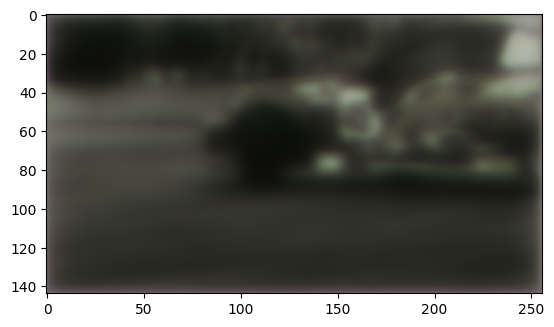

In [33]:
plt.imshow(torch.permute(result[0].detach().cpu(), (1, 2, 0)))

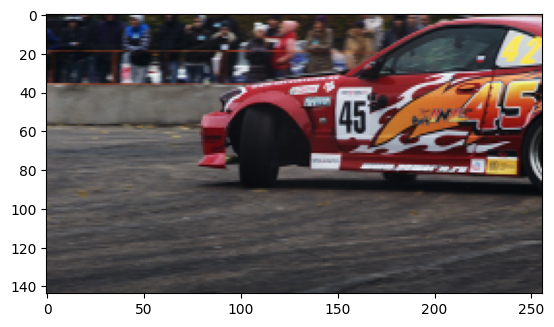

In [34]:
plt.imshow(torch.permute(d[0][1][0].cpu(), (1, 2, 0)))

In [22]:
s

b''